# Support Vector Machines

The **perceptron algorithm** calculates the decision line between two linearly separable classes clustered in feature space. We note that the solution found by the perceptron is not unique. Running the algorithm with a different set of initial weights will give you a different but equally valid solution. 

What if we want to find the best decision line between the two classes? By “best” we mean that the decision line should be the one that offers the best generalization when tested with novel data. Visually, the best decision line
should have the **largest margin between the two classes** as shown below. For linearly separable classes the solution to the best decision line is unique.

<center> 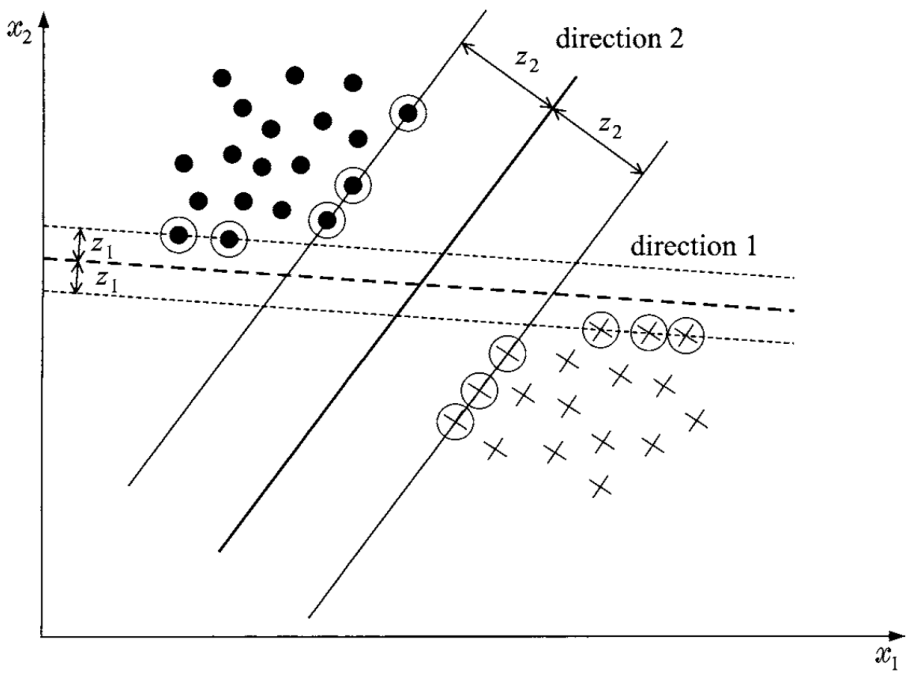 </center>

If the best decision line is given by 

$$ g(x) = w_0 + x^T\mathbf{w} = 0 $$ 

the perpendicular distance $z$ is given by 

$$ z = \frac{g(x)}{||\mathbf{w}||} $$

We can then scale $\mathbf{w}$ and $||w||$ such that the value of $g(x)$ is $1$ for $\omega_1$ and $-1$ for $\omega_2$. This is equivalent to imposing that the margin is given by

$$ \frac{1}{||\mathbf{w}||} + \frac{1}{||\mathbf{w}||} = \frac{2}{||\mathbf{w}||} $$

is maximized and that

$$ \begin{cases} w_0 + x^T\mathbf{w} \geq 1, & \text{for all} \quad x \in \omega_1 \\ w_0 + x^T\mathbf{w} \leq -1, & \text{for all} \quad x \in \omega_2 \end{cases} $$

Recall that for each data point $\mathbf{x}_i$, we indicae the class $y_i$ which is $+1$ for $\omega_1$ and $-1$ for $\omega_2$. Our two conditions above can therefore be efficiently rewritten as follows:

> Minimize $$ J(\omega) = \frac{1}{2} ||\mathbf{w}||^2 $$
subject to the constraint $$ y_i \left(w_0 + x^T\mathbf{w} \right)
\geq 1 $$ for all $ i = 1,2,3,\cdots,N$.

Using Lagrange multipliers $\lambda_i$, we can convert the margin approximation problem given by

> The function $$ \text{min} \; L_p = \frac{1}{2} ||w||^2 - \sum_{i=1}^{N} \lambda_iy_i \left( w_0 + x_i^T\mathbf{w} \right) + \sum_{i=1}^N \lambda_i $$ subject to the constraints $$ \begin{cases} w = \sum_{i=1}^N \lambda_iy_ix_i \\ \sum_{i=1}^N \lambda_iy_i=0 \\ \lambda_i \geq 0 \end{cases} $$

where $N$ is the number of training points, to a problem involving only dot products given by 

> The function $$ \text{max} \; L_D(\lambda_i) = \sum_{i=1}^N \lambda_i - \frac{1}{2} \sum{i=1}^N \sum{j=1}^N \lambda_i \lambda_j y_iy_j \left(\mathbf{x}_i \cdot \mathbf{x}_j\right) $$ subject to the constraints $$ \begin{cases} \sum_{i=1}^N \lambda_iy_i = 0 \\ \lambda_i \geq 0 \end{cases} $$

Finding the decision line with the widest margin from the nearest feature vectors using the equations above with constraints is an optimization problem. Using such quadratic problem solver packages like `cvxopt` and `numpy`, we can the solve for $\lambda_i$ and use $ \text{min} \; L_p $ to solve for $\mathbf{w}$ to solve for weights $\mathbf{w}$ and bias $w_0$.

In [1]:
import numpy as np
import pandas as pd
import qpsolvers as qp
import cv2, glob, random
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
# plt.rcParams["text.usetex"] = True

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## SVM algorithm

In [2]:
def SVM(data1, data2, index = 0):
    samples = np.hstack([data1, data2])
    features = np.array(samples).T
    
     # initialize labels for both classes
    labels = np.ones(np.shape(features)[0]) # vector z
    labels[np.shape(features)[0]//2:] = -1
    labels_mod = labels.reshape((np.shape(features)[0], 1))
    
    # matrix H - product of feature and label vectors
    H = (features @ features.T) * (labels_mod @ labels_mod.T)
    
    # initialize optimization vectors for quadprog
    f = -np.ones(np.shape(features)[0])
    A = -np.eye(np.shape(features)[0])
    a = np.zeros(np.shape(features)[0])
    B = np.vstack((labels, np.zeros((np.shape(features)[0] - 1, np.shape(features)[0]))))
    b = np.zeros(np.shape(features)[0])
    
    # Lagrange multipliers and solution
    stabilizer = np.eye(np.shape(features)[0]) * 0.001
    alpha = qp.solve_qp(H + stabilizer, f, A, a, B, b)
    alpha_index = np.where(alpha > 0)[0]
    
    # line parameters and maximal margin
    w = (alpha * labels.T) @ features
    w0 = 1/(labels[alpha_index[index]]) - w.T @ features[alpha_index[index]]
    A, B, C = w[0], w[1], -w0
    slope, intercept = -A/B , C/B
    margin = 1/np.linalg.norm(w)
    boundary = np.sqrt(1 + slope**2) * margin
    
    return slope, intercept, boundary

***
## Fruits dataset